# Transfer learning

We will load a pretrained model (our model trained on MNIST) and fine-tune it on the more complex KMNIST dataset http://codh.rois.ac.jp/kmnist/index.html.en (https://github.com/rois-codh/kmnist)


![](kmnist.png)

We also address the following question:
- how different are the two datasets?

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torchsummary import summary

import numpy as np
from matplotlib import pyplot as plt

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [4]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [5]:
input_size=(1,28,28,)
batch_size=64
test_batch_size=1000
seed=1101

In [6]:
use_cuda = torch.cuda.is_available()
torch.manual_seed(seed)
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [7]:
train_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True, **kwargs)

In [8]:
model = Net().to(device)

In [9]:
summary(model,input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 24, 24]             520
            Conv2d-2             [-1, 50, 8, 8]          25,050
            Linear-3                  [-1, 500]         400,500
            Linear-4                   [-1, 10]           5,010
Total params: 431,080
Trainable params: 431,080
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.12
Params size (MB): 1.64
Estimated Total Size (MB): 1.76
----------------------------------------------------------------


In [10]:
model.load_state_dict(torch.load('mnist_cnn.pt'))
model.eval()

Net(
  (conv1): Conv2d(1, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(20, 50, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=800, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
)

In [12]:
inputs,labels = next(iter(test_loader))

In [13]:
inputs.shape

torch.Size([1000, 1, 28, 28])

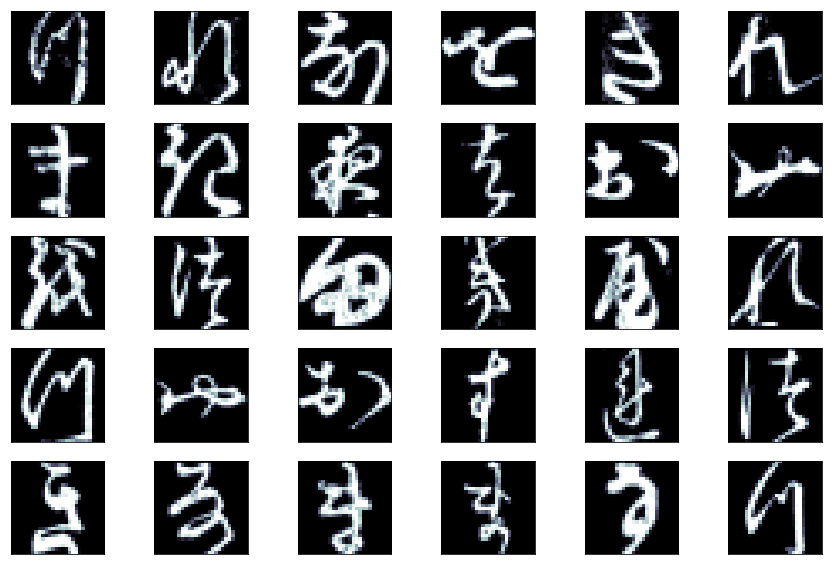

In [14]:
fig=plt.figure(figsize=(15,10))
for i in range(30):
    plt.subplot(5,6,i+1)
    plt.imshow(np.squeeze(inputs[i]),cmap='bone')
    plt.xticks([])
    plt.yticks([])

In [15]:
output = model(inputs)
pred = output.argmax(dim=1, keepdim=True) 
correct = pred.eq(labels.view_as(pred)).sum().item()
print('acc = {}'.format(correct/inputs.shape[0]) )

acc = 0.077


In [15]:
# ... from our Net class
#self.fc1 = nn.Linear(4*4*50, 500)
#self.fc2 = nn.Linear(500, 10)

In [16]:
for p in model.parameters():
    print(p.shape)

torch.Size([20, 1, 5, 5])
torch.Size([20])
torch.Size([50, 20, 5, 5])
torch.Size([50])
torch.Size([500, 800])
torch.Size([500])
torch.Size([10, 500])
torch.Size([10])


In [17]:
list(model.parameters())[-2]

Parameter containing:
tensor([[ 0.0368,  0.0177,  0.0514,  ..., -0.0677, -0.0038, -0.0260],
        [ 0.0622,  0.0171, -0.0215,  ...,  0.0587, -0.0119,  0.0519],
        [-0.0541,  0.0312,  0.0295,  ...,  0.0866, -0.0999, -0.0542],
        ...,
        [ 0.0391,  0.0551,  0.0057,  ...,  0.0392, -0.0121,  0.0594],
        [-0.0261, -0.0312, -0.0203,  ...,  0.0133,  0.0337, -0.0277],
        [-0.0369,  0.0372,  0.0052,  ..., -0.0538, -0.0175, -0.0228]],
       requires_grad=True)

In [18]:
model.fc2 = nn.Linear(500,10)

In [19]:
list(model.parameters())[-2]

Parameter containing:
tensor([[ 0.0142,  0.0306,  0.0379,  ..., -0.0265,  0.0400,  0.0020],
        [-0.0053, -0.0210, -0.0257,  ...,  0.0028, -0.0294, -0.0403],
        [-0.0167, -0.0260,  0.0168,  ...,  0.0073,  0.0196,  0.0241],
        ...,
        [ 0.0362, -0.0337,  0.0159,  ..., -0.0190,  0.0214, -0.0198],
        [-0.0126,  0.0175, -0.0238,  ...,  0.0161,  0.0248, -0.0263],
        [ 0.0102,  0.0036,  0.0030,  ...,  0.0149,  0.0039,  0.0313]],
       requires_grad=True)

In [20]:
epochs=10
lr=0.01
momentum=0.0
seed=1
log_interval=100
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)
save=False

In [21]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    
if save:
    torch.save(model.state_dict(),"kmnist_trans_fc2.pt")

Train Epoch: 1 [0/60000 (0%)]	Loss: 3.127351
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.608064
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.346216
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.331569
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.213837
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.246416
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.151573
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.277286
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.193626
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.167364

Test set: Average loss: 0.5166, Accuracy: 8442/10000 (84%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.227334
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.183211
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.130946
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.134985
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.100538
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.087203
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.149872
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.242094
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.122180
T

# Exercise

Experiment *freely* with these topics:
- number of epochs (up to 10 for time saving)
- extension of random initialization to the second last hidden layer
- monitor test and train loss and accuracy: does the model overfit?
- regularize it with dropout (*)

(*) You will have to redefine the Net class, adding the dropout layers after the feature extractions (after the second max pooling layer) and after fully connected fc1. Take inspiration from this architecture https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py (which is written in Keras, by the way). Then you have to re-train the model on MNIST and experiment again with transfer learning on KMNIST.

# Intrinsic dimensionality

Let's see how different these two datasets are. We look at their intrinsic dimension 

In [65]:
nsamples=5000
sampleKMNISTloader = torch.utils.data.DataLoader(
        datasets.KMNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

sampleMNISTloader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=nsamples, shuffle=True, **kwargs)

In [66]:
sample_kmnist,_ = next(iter(sampleKMNISTloader))
sample_mnist,_ = next(iter(sampleMNISTloader))

In [67]:
from intrinsic_dimension import estimate,block_analysis

In [68]:
print(sample_kmnist.shape)
print(sample_mnist.shape)

torch.Size([5000, 1, 28, 28])
torch.Size([5000, 1, 28, 28])


In [69]:
sample_kmnist = np.reshape(np.squeeze(sample_kmnist), (nsamples, -1) )
sample_mnist = np.reshape(np.squeeze(sample_mnist), (nsamples, -1) )

In [70]:
from scipy.spatial.distance import pdist,squareform

In [71]:
#?estimate

In [72]:
kmnist_est = estimate(squareform(pdist(sample_kmnist)), verbose=True)
mnist_est = estimate(squareform(pdist(sample_mnist)), verbose=True)

Found n. 0 elements for which r1 = 0
[]
Found n. 0 elements for which r1 = r2
[]
Fraction good points: 1.0
Found n. 0 elements for which r1 = 0
[]
Found n. 0 elements for which r1 = r2
[]
Fraction good points: 1.0


In [73]:
print(kmnist_est[2])

17.43003637365327


In [74]:
print(mnist_est[2])

12.84885223941517


In [75]:
?block_analysis

In [76]:
kmnist_ba = block_analysis(squareform(pdist(sample_kmnist)))
mnist_ba = block_analysis(squareform(pdist(sample_mnist)))

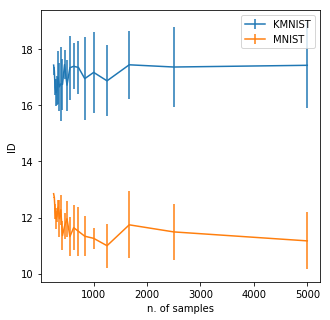

In [77]:
fig=plt.figure(figsize=(5,5))
plt.errorbar(kmnist_ba[2][::-1],kmnist_ba[0],yerr=kmnist_ba[1],label='KMNIST')
plt.errorbar(mnist_ba[2][::-1],mnist_ba[0],yerr=mnist_ba[1],label='MNIST')
plt.xlabel('n. of samples')
plt.ylabel('ID')
plt.legend()
plt.savefig('KMNIST_ID.png')
plt.show()